<a href="https://colab.research.google.com/github/rafiqmyura/Learn-Machine-Learning/blob/main/Flower_Detection_Type_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


# import data handling tools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Warning Notification

import warnings
warnings.filterwarnings("ignore")

print('modules loaded')

modules loaded


## Data Preprocessing

**Read DataFrame and Store**

In [ ]:
data_dir= '/content/drive/MyDrive/frayer data/flower_images'
filepath = []
labels = []

folds = os.listdir(data_dir)
for fold in folds :
  foldpath = os.path.join(data_dir, fold)
  filelist = os.listdir(foldpath)
  for file in filelist:
    fpath = os.path.join(foldpath, file)
    filepath.append(fpath)
    labels.append(fold)


Fseries = pd.Series(filepath, name= 'filepath')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [ ]:
df

,filepath,labels
0,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
1,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
2,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
3,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
4,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
...,...,...
4995,/content/drive/MyDrive/frayer data/flower_imag...,Tulip
4996,/content/drive/MyDrive/frayer data/flower_imag...,Tulip
4997,/content/drive/MyDrive/frayer data/flower_imag...,Tulip
4998,/content/drive/MyDrive/frayer data/flower_imag...,Tulip


In [ ]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)


valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4000 validated image filenames belonging to 5 classes.
Found 600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.


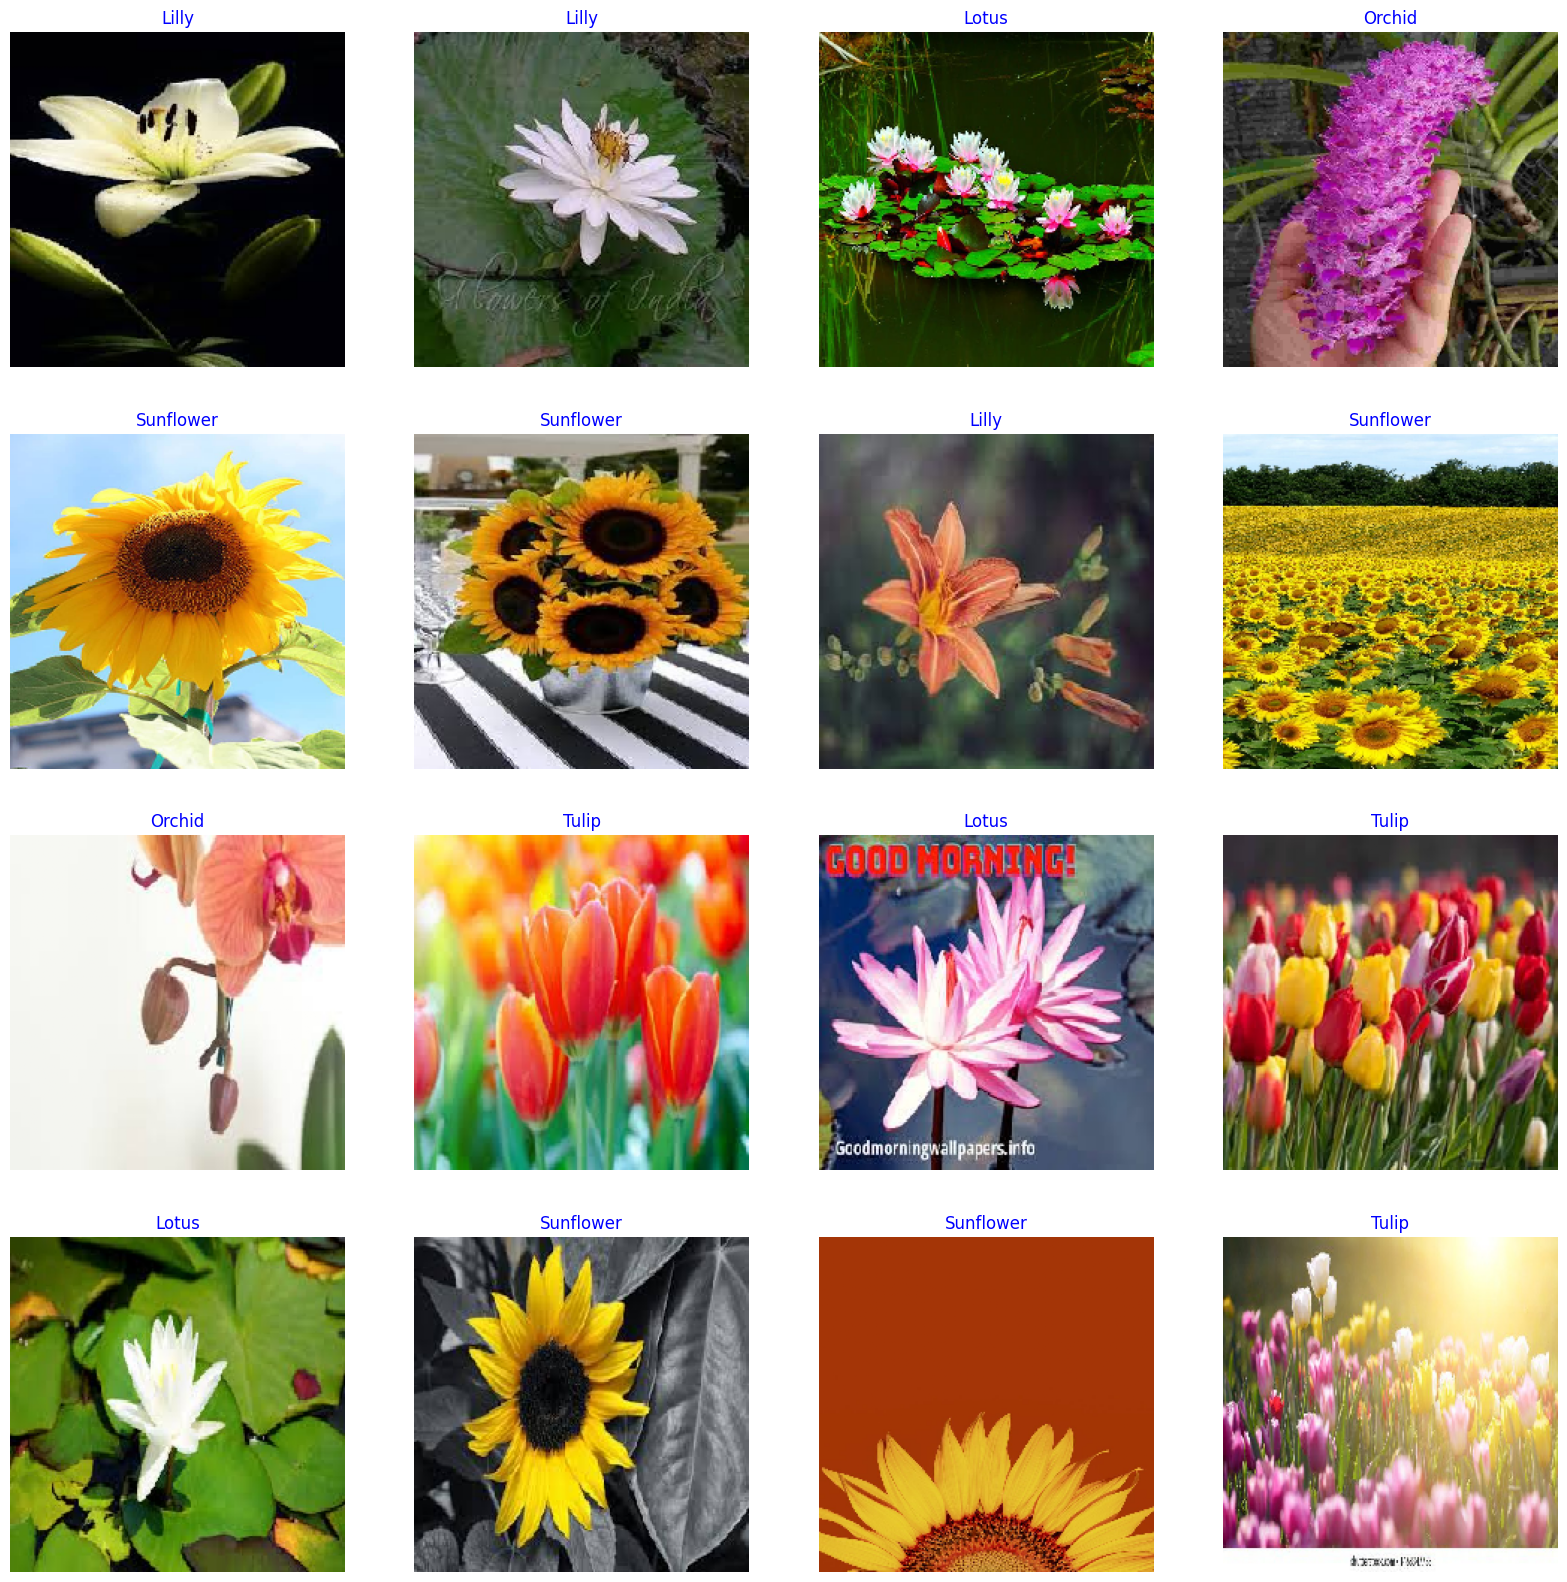

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

### Module Structure

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                         

In [ ]:
batch_size = 16   # set batch size for training
epochs = 10  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
250/250 [==============================] - 1166s 4s/step - loss: 7.0271 - accuracy: 0.7778 - val_loss: 5.3387 - val_accuracy: 0.9483
Epoch 2/10
250/250 [==============================] - 72s 286ms/step - loss: 4.3258 - accuracy: 0.9270 - val_loss: 3.4323 - val_accuracy: 0.9450
Epoch 3/10
250/250 [==============================] - 72s 290ms/step - loss: 2.7886 - accuracy: 0.9610 - val_loss: 2.1788 - val_accuracy: 0.9667
Epoch 4/10
250/250 [==============================] - 71s 285ms/step - loss: 1.7837 - accuracy: 0.9720 - val_loss: 1.4140 - val_accuracy: 0.9767
Epoch 5/10
250/250 [==============================] - 72s 289ms/step - loss: 1.1753 - accuracy: 0.9768 - val_loss: 0.9379 - val_accuracy: 0.9783
Epoch 6/10
250/250 [==============================] - 71s 285ms/step - loss: 0.7868 - accuracy: 0.9868 - val_loss: 0.6451 - val_accuracy: 0.9767
Epoch 7/10
250/250 [==============================] - 72s 289ms/step - loss: 0.5566 - accuracy: 0.9852 - val_loss: 0.4731 - val_acc